In [ ]:
! pip install transformers datasets
! pip install accelerate

In [ ]:
from transformers import DPTImageProcessor, DPTForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import tqdm
from scipy.spatial import distance
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection 
from matplotlib import style

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
i1 = "/content/drive/MyDrive/ifind_hand_label_data/Frame number-65 Video Name- FC148ESE:FC148ESE_raw_clip_example_1.png"
il_object = np.array([792, 796])
i1_child = np.array([[960, 540], [768, 364]])
i1_parent = np.array(((840, 310), (1080, 135)))

i2 = "/content/drive/MyDrive/ifind_hand_label_data/Frame number-151 Video Name- FC126ESE:FC126ESE_raw_clip_example_0.png"
i2_object = np.array([960, 531])
i2_child = np.array([[960, 180], [1152, 405]])
i2_parent = np.array([[432, 90], [624, 315]])

i3 = "/content/drive/MyDrive/ifind_hand_label_data/Frame number-344 Video Name- FC107EEB:FC107EEB_raw_clip_example_0.png"
i3_object = np.array([320, 540])
i3_child = np.array(((355, 216), (473, 338)))
i3_parent = np.array(((720, 135), (936, 472)))

i4 = "/content/drive/MyDrive/ifind_hand_label_data/Frame number-149 Video Name- FC148EBF:FC148EBF_raw_clip_example_1.png"
i4_object = np.array((1680, 742))
i4_child = np.array([[355, 216], [473, 338]])
i4_parent = np.array([[972, 86], [844, 244]])

i5 = "/content/drive/MyDrive/ifind_hand_label_data/WB003ENM_raw_clip_example_14_frame_69_y.jpg"
i5_object = np.array(( 1919 , 1079 ))
i5_child = np.array(((1017, 486), (1248, 702)))
i5_parent = np.array(((864, 453), (576, 162)))


i6 = "/content/drive/MyDrive/ifind_hand_label_data/FS019ESF_raw_clip_example_12_frame_19_y.jpg"
i6_object = np.array(( 1279 ,719) )
i6_child = np.array(((358, 396), (524, 540)))
i6_parent = np.array(((537, 432), (678, 251)))


i7 = "/content/drive/MyDrive/ifind_hand_label_data/FC126F05_2of2_frame_432_y.jpg"
i7_object = np.array(( 479 ,359))
i7_child = np.array(((254, 162), (312, 234)))
i7_parent = np.array(((216, 151), (144, 54)))


i8 = "/content/drive/MyDrive/ifind_hand_label_data/frame_1.jpg"
i8_object = np.array((719 , 660))
i8_child = np.array(((947, 338), (1088, 482)))
i8_parent = np.array(((486, 338), (652, 122)))

In [ ]:
  processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
  model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_boxpoints(points):
  # Compute the width and height of the box
  width = points[1][0] - points[0][0]
  height = points[1][1] - points[0][1]

  # Create two new points that complete the box
  point3 = [points[0][0], points[0][1]+height]
  point4 = [points[1][0], points[1][1]-height]

  # Combine the four points into an array
  box_points = np.array([points[0], point3, points[1], point4])
  return box_points


def get_midpoint(points):
  avg_x = np.mean(points[:, 0])
  avg_y = np.mean(points[:, 1])

  # Create a new point that represents the middle of the box
  middle_point = np.array([avg_x, avg_y]).astype(int)
  return middle_point

def get_z_coordinate( formatted, point):
  return np.hstack((point, formatted[point[1],point[0]]))

def get_z_coordinate_object( formatted, point):
  return np.hstack((point, formatted[point[0],point[1]]))

def get_triangle_area(p1,p2,p3):
  v1 = p2 - p1
  v2 = p3 - p1

  # Calculate the cross product of the two vectors
  cross = np.cross(v1, v2)

  # Calculate the area of the triangle as half the magnitude of the cross product
  area =  0.5 * distance.euclidean(cross, np.array([0, 0, 0]))
  return area

def get_depth(i,processor,model):
  image = Image.open(i)


  #processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
  #model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

  # prepare image for the model
  inputs = processor(images=image, return_tensors="pt")

  with torch.no_grad():
      outputs = model(**inputs)
      predicted_depth = outputs.predicted_depth

  # interpolate to original size
  prediction = torch.nn.functional.interpolate(
      predicted_depth.unsqueeze(1),
      size=image.size[::-1],
      mode="bicubic",
      align_corners=False,
  )

  # visualize the prediction
  output = prediction.squeeze().cpu().numpy()
  formatted = (output * 255 / np.max(output)).astype("uint8")
  return formatted

In [ ]:
images = [[i1,il_object,i1_child,i1_parent],
          [i2,i2_object,i2_child,i2_parent],
          [i3,i3_object,i3_child,i3_parent],
          [i4,i4_object,i4_child,i4_parent],
          [i5,i5_object,i5_child,i5_parent],
          [i6,i6_object,i6_child,i6_parent],
          [i7,i7_object,i7_child,i7_parent],
          [i8,i8_object,i8_child,i8_parent]]
areas = []
for L in tqdm.tqdm(images):
  print(L[0])
  formatted = get_depth(L[0],processor,model)
  print(formatted.shape)
  point1 = get_midpoint(L[2])
  point2 = get_midpoint(L[3])
  p1 = get_z_coordinate(formatted,L[1])
  p2 = get_z_coordinate(formatted,point1)
  p3 = get_z_coordinate(formatted,point2)
  a = get_triangle_area(p1,p2,p3) / (formatted.shape[0] * formatted.shape[1] )
  areas.append(a)


  0%|          | 0/8 [00:00<?, ?it/s]

/content/drive/MyDrive/ifind_hand_label_data/Frame number-65 Video Name- FC148ESE:FC148ESE_raw_clip_example_1.png


 12%|█▎        | 1/8 [00:09<01:04,  9.21s/it]

(1080, 1920)
/content/drive/MyDrive/ifind_hand_label_data/Frame number-151 Video Name- FC126ESE:FC126ESE_raw_clip_example_0.png


 25%|██▌       | 2/8 [00:18<00:55,  9.20s/it]

(720, 1280)
/content/drive/MyDrive/ifind_hand_label_data/Frame number-344 Video Name- FC107EEB:FC107EEB_raw_clip_example_0.png


 38%|███▊      | 3/8 [00:28<00:47,  9.46s/it]

(720, 1280)
/content/drive/MyDrive/ifind_hand_label_data/Frame number-149 Video Name- FC148EBF:FC148EBF_raw_clip_example_1.png


 50%|█████     | 4/8 [00:35<00:34,  8.70s/it]

(1080, 1920)
/content/drive/MyDrive/ifind_hand_label_data/WB003ENM_raw_clip_example_14_frame_69_y.jpg


 62%|██████▎   | 5/8 [00:45<00:27,  9.08s/it]

(1080, 1920)
/content/drive/MyDrive/ifind_hand_label_data/FS019ESF_raw_clip_example_12_frame_19_y.jpg


 75%|███████▌  | 6/8 [00:53<00:17,  8.80s/it]

(720, 1280)
/content/drive/MyDrive/ifind_hand_label_data/FC126F05_2of2_frame_432_y.jpg


 88%|████████▊ | 7/8 [01:03<00:08,  8.99s/it]

(360, 480)
/content/drive/MyDrive/ifind_hand_label_data/frame_1.jpg


100%|██████████| 8/8 [01:12<00:00,  9.07s/it]

(720, 1280)


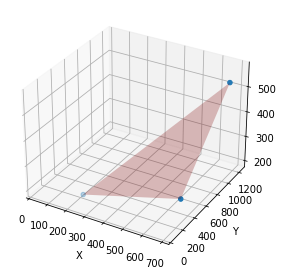

In [ ]:
#https://stackoverflow.com/questions/54859741/how-to-create-3d-triangle-with-3-point-using-matplotlib-python
formatted = get_depth(i8,processor,model)
plt.figure('SPLTV',figsize=(10,5))
custom=plt.subplot(121,projection='3d')

x1= get_z_coordinate(formatted,i8_object)

y1=get_z_coordinate(formatted,get_midpoint(i8_child))
z1=get_z_coordinate(formatted,get_midpoint(i8_parent))


custom.scatter(x1,y1,z1)

# 1. create vertices from points
verts = [list(zip(x1, y1, z1))]
# 2. create 3d polygons and specify parameters
srf = Poly3DCollection(verts, alpha=.25, facecolor='#800000')
# 3. add polygon to the figure (current axes)
plt.gca().add_collection3d(srf)

custom.set_xlim3d(0, formatted.shape[0])
custom.set_ylim3d(0, formatted.shape[1])
custom.set_xlabel('X')
custom.set_ylabel('Y')
custom.set_zlabel('Z')
plt.show()

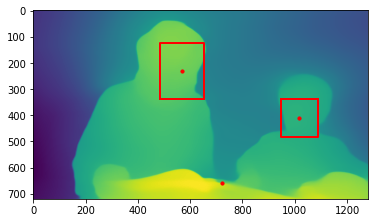

In [ ]:
image_copy = np.array(depth)
points = get_boxpoints(i8_child)
points1 = get_boxpoints(i8_parent)
point3 = get_midpoint(i8_parent)
point4 = get_midpoint(i8_child)

plt.scatter(i8_object[0], i8_object[1], s=10, color='red')
plt.plot(points[:, 0], points[:, 1], color='red', linewidth=2)
plt.plot([points[0][0], points[-1][0]], [points[0][1], points[-1][1]], color='red', linewidth=2)
plt.plot(points1[:, 0], points1[:, 1], color='red', linewidth=2)
plt.plot([points1[0][0], points1[-1][0]], [points1[0][1], points1[-1][1]], color='red', linewidth=2)
plt.scatter(point3[0], point3[1], s=10, color='red')
plt.plot([points1[0][0], points1[-1][0]], [points1[0][1], points1[-1][1]], color='red', linewidth=2)
plt.scatter(point4[0], point4[1], s=10, color='red')
plt.imshow(image_copy)
plt.show()

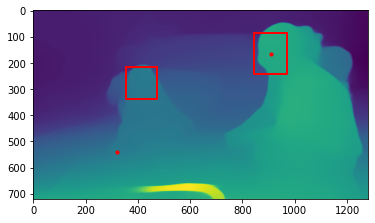

In [ ]:
image = Image.open(i3)
image_copy = np.array(depth)



points = get_boxpoints(i8_child)
points1 = get_boxpoints(i8_parent)
point3 = get_midpoint(i8_parent)
point4 = get_midpoint(i8_child)
# Draw a red point at the specified coordinates
plt.scatter(i8_object[0], i8_object[1], s=10, color='red')
plt.plot(points[:, 0], points[:, 1], color='red', linewidth=2)
plt.plot([points[0][0], points[-1][0]], [points[0][1], points[-1][1]], color='red', linewidth=2)
plt.plot(points1[:, 0], points1[:, 1], color='red', linewidth=2)
plt.plot([points1[0][0], points1[-1][0]], [points1[0][1], points1[-1][1]], color='red', linewidth=2)
plt.scatter(point3[0], point3[1], s=10, color='red')
plt.plot([points1[0][0], points1[-1][0]], [points1[0][1], points1[-1][1]], color='red', linewidth=2)
plt.scatter(point4[0], point4[1], s=10, color='red')
plt.imshow(image_copy)
plt.show()